# Figura 8: Comparación Algoritmos

En el ejemplo, comparamos **K-Medias**, **DBScan**, y **MeanShift**.
Es muy difícil para K-Means.
MeanShift es automático.
DBScan está optimizado, el valor de `eps` cambia con cada grupo de datos.

In [1]:
import time
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

from itertools import cycle, islice

np.random.seed(0)

In [2]:
"""
Generate datasets...
We choose the size big enough to see the scalability of
the algorithms, but not too big to avoid too long running times
"""
n_samples = 1500

noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)

noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

blobs = datasets.make_blobs(n_samples=n_samples, random_state=10)

no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 100

X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)

transformation = [ [0.6, -0.6]
                 , [-0.4, 0.8]
                 ]

X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# Blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

In [3]:
# ============
# Set up cluster parameters
# ============
plot_num = 1

default_base = { 'quantile': .3
               , 'eps': .3
               , 'damping': .9
               , 'preference': -200
               , 'n_neighbors': 10
               , 'n_clusters': 3
               , 'min_samples': 20
               , 'xi': 0.05
               , 'min_cluster_size': 0.1
               }

datasets = [
    (noisy_circles, {'damping': .77,
                     'preference': -240,
                     'quantile': .2,
                     'n_clusters': 2,
                     'min_samples': 20,
                     'xi': 0.25}
    ),
    (noisy_moons, {'damping': .75,
                   'preference': -220,
                   'n_clusters': 2}
    ),
    (varied, {'eps': .18,
              'n_neighbors': 2,
              'min_samples': 5,
              'xi': 0.035,
              'min_cluster_size': .2}
    ),
    (aniso, {'eps': .15,
             'n_neighbors': 2,
             'min_samples': 20,
             'xi': 0.1,
             'min_cluster_size': .2}
    ),
    (blobs, {}),
    (no_structure, {})
]

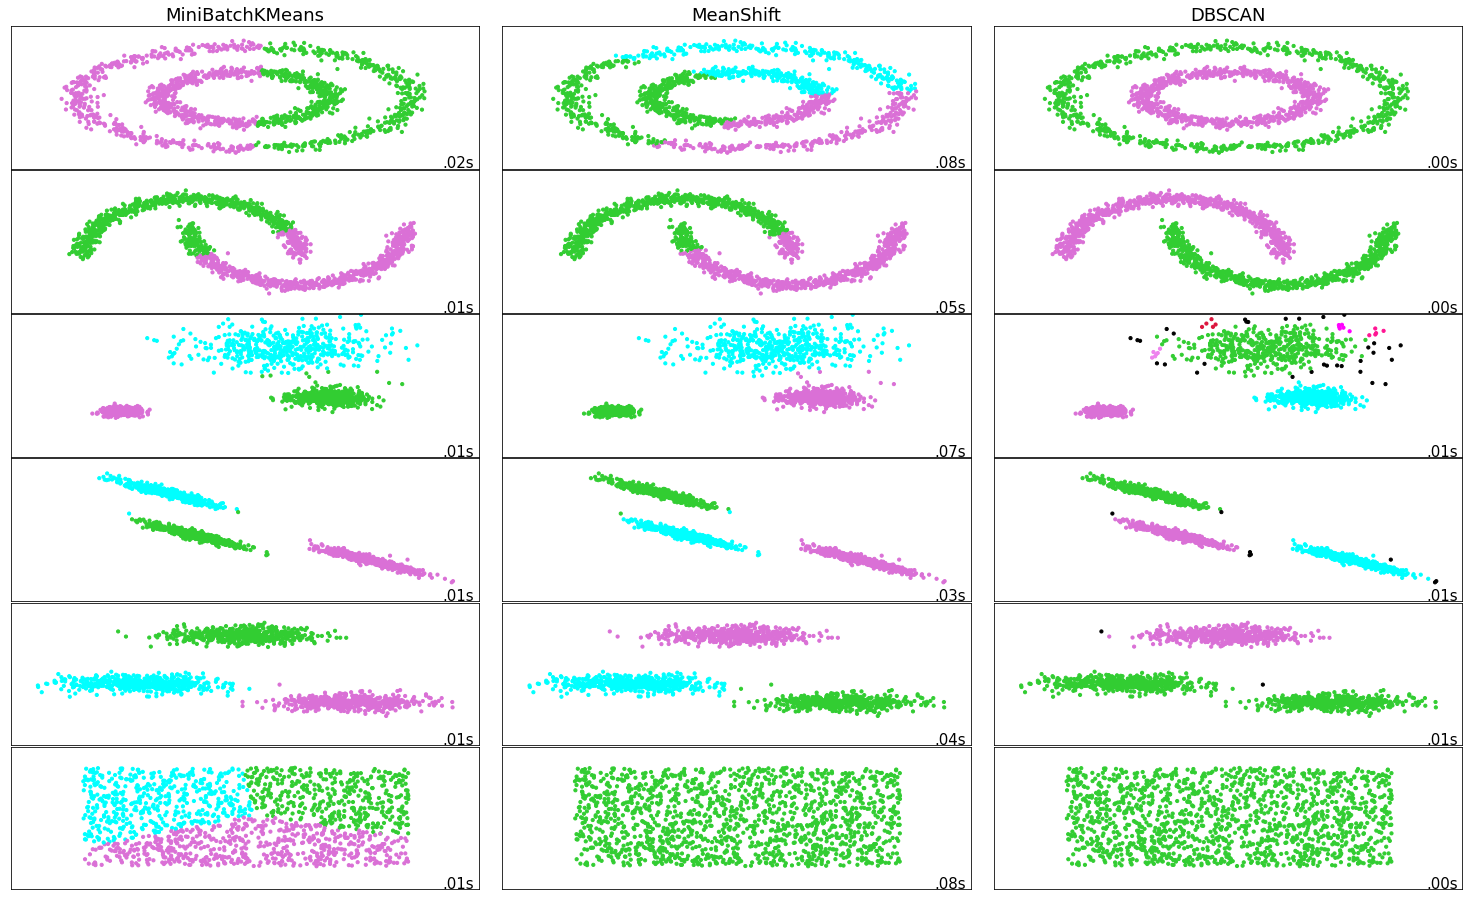

In [4]:
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

for i_dataset, (dataset, algorithm_params) in enumerate(datasets):
    # Update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algorithm_params)

    X, y = dataset

    # Normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # Estimate bandwidth for MeanShift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # ============
    # Create cluster objects
    # ============
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])

    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

    dbscan = cluster.DBSCAN(eps=params['eps'])

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('MeanShift', ms),
        ('DBSCAN', dbscan)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # Fit the clustering
        algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(
            cycle(
                ['limegreen', 'orchid', 'aqua', 'violet', 'magenta', 'deeppink', 'crimson', 'fuchsia', 'blue']
            ),
            int(max(y_pred) + 1)
        )))

        # Add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99,
                 .01,
                 ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes,
                 size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()